In [11]:
import os
import numpy as np
import librosa
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
import wandb
import torch.optim as optim
from featureblocks_16khz import FeatureBlock3

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
!export CUDA_VISIBLE_DEVICES=2

In [35]:
folds = os.listdir('./folded_dataset_16khz/')
print(folds)

['fold1.pt', 'fold10.pt', 'fold2.pt', 'fold3.pt', 'fold6.pt', 'fold4.pt', 'fold7.pt', 'fold5.pt', 'fold9.pt', 'fold8.pt']


In [14]:
frame_length = 1000
overlapping_fraction = 0.1
data = torch.load('./torch_dataset_1sec/all_audio_data.pt')
print(data.size())

X_train = data[:,0:frame_length].clone()
test_portion = int(0.79*((data.size())[0]))
print(test_portion)
X_train = data[:test_portion, 0:frame_length].clone()

Y_train = data[:test_portion,frame_length:].clone()

X_train = X_train.reshape(-1, 16,250)
print(X_train.size())
Y_train = Y_train.type(torch.LongTensor)
Y_train_one_hot = F.one_hot(Y_train)
print(Y_train_one_hot.size())

torch.Size([558365, 1001])
441108
torch.Size([110277, 16, 250])
torch.Size([441108, 1, 10])


In [15]:
!export CUDA_VISIBLE_DEVICES=2

In [16]:
X_eval = torch.load("./X_eval0713_2.torch")
print(X_eval.size())
X_eval = X_eval.reshape(-1, 16, 1000)
print(X_eval.size())
Y_eval = torch.load("./Y_eval0713_2.torch")
#Y_eval = Y_eval.reshape(-1, 16, 1000)

audio_testset = TensorDataset (X_eval, Y_eval)
audio_testloader = DataLoader (audio_testset, batch_size = 10, shuffle= True)

torch.Size([10807, 16, 1000])
torch.Size([10807, 16, 1000])


In [17]:
model = FeatureBlock3().float().cuda()
checkpoint = torch.load("./model0713_2.torch", map_location=lambda storage, loc: storage.cuda(2))
model.load_state_dict(checkpoint['model_state_dict'])
print(checkpoint["loss"])

1.5826419336947402


In [18]:
train_accu = torch.load("./train_accu0713_2.torch")
#eval_accu =  torch.load("./eval_accu0712_3.torch")
#print(eval_accu)
ave_accu = sum(train_accu)/300
train_losses = torch.load("./train_losses0713_2.torch")
ave_losses = sum(train_losses)/300
print(ave_accu, ave_losses)



269.7387220654233 5.505928368563825


In [19]:
loss_function = torch.nn.CrossEntropyLoss()
iteration = 0
losses = []

eval_losses=[]
eval_accu=[]

running_loss=0
correct=0
total=0
model = model.cuda(2)

for index,(x,y) in enumerate(audio_testloader):
    
    y_hat = y.type(torch.LongTensor)
    y_hat = y_hat.cuda(2)

    outputs = model(x.float().cuda(2))
    y_hat = y_hat.squeeze(1)
    #import pdb; pdb.set_trace()
    loss = loss_function(outputs,y_hat)
    
    _, predicted = outputs.max(1)
    total = y_hat.size(0)
    correct = predicted.eq(y_hat).sum().item()

    print("iteration:{} loss:{} ".format(iteration, loss.item()))
    losses.append(loss)
    iteration += 1
    
    accu=100.*correct/total
 
    eval_losses.append(loss.item())
    eval_accu.append(accu)

ave_accu = sum(eval_accu)/len(eval_accu)
ave_loss  =sum(eval_losses)/len(eval_losses)
print('Test Loss: %.3f | Accuracy: %.3f'%(ave_loss,ave_accu)) 


/home/nazzy/.local/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


iteration:0 loss:2.056180238723755 
iteration:1 loss:2.0611495971679688 
iteration:2 loss:2.455850124359131 
iteration:3 loss:1.9609496593475342 
iteration:4 loss:2.1611504554748535 
iteration:5 loss:1.9611504077911377 
iteration:6 loss:2.061150312423706 
iteration:7 loss:2.261150360107422 
iteration:8 loss:2.0587048530578613 
iteration:9 loss:2.2612102031707764 
iteration:10 loss:1.9611504077911377 
iteration:11 loss:2.160529613494873 
iteration:12 loss:2.1231815814971924 
iteration:13 loss:2.2492899894714355 
iteration:14 loss:2.1536619663238525 
iteration:15 loss:1.9611949920654297 
iteration:16 loss:2.160863161087036 
iteration:17 loss:1.958709716796875 
iteration:18 loss:2.060832977294922 
iteration:19 loss:2.261150360107422 
iteration:20 loss:1.9594199657440186 
iteration:21 loss:2.1615653038024902 
iteration:22 loss:2.0602142810821533 
iteration:23 loss:1.9611504077911377 
iteration:24 loss:2.2606163024902344 
iteration:25 loss:2.1611504554748535 
iteration:26 loss:2.26115036010

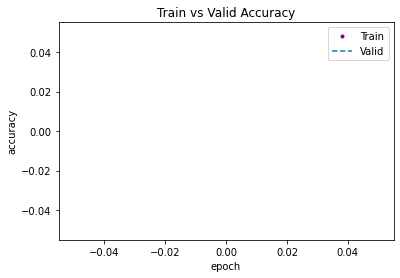

In [7]:
import matplotlib.pyplot as plt

plt.plot(train_accu,'.',color= 'purple')
plt.plot(eval_accu,'--')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')
 
plt.show()


In [5]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
from os import path
import math
import sys

class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred.float() + 1), torch.log(actual.float() + 1))

from featureblocks_16khz import FeatureBlock3

model_name = "model_fold1.pt"
frame_length = 16000
overlapping_fraction = 0.1
data = torch.load('./folded_dataset_16khz/fold1.pt')


# Shuffle dataset before we do anything
#data=data[torch.randperm(data.size()[0])]
#X_train = data[:,0:frame_length].clone()
#test_portion = int(0.80*((data.size())[0]))

X_eval = data[:,0:frame_length].clone()
X_eval = X_eval.reshape(-1, 16, 1000)
Y_eval = data[:,frame_length:].clone()


audio_testset = TensorDataset (X_eval, Y_eval)
audio_testloader = DataLoader (audio_testset, batch_size = 50, shuffle= True)


# The trinity of models
model = FeatureBlock3().cuda()
loss_function = torch.nn.CrossEntropyLoss()
T_max = 500
iteration = 0


# Load model if exists
if path.exists(model_name):
    checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage.cuda())
    model.load_state_dict(checkpoint['model_state_dict'])
    #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_loss = checkpoint['loss']
    print("Loaded model from {} with loss {}".format(model_name, checkpoint['loss']))

model.eval()

train_accu = []
train_losses = []

eval_losses=[]
eval_accu=[]



running_loss=0
correct=0
total=0
losses = []

with torch.no_grad():

    for index,(x,y) in enumerate(audio_testloader):

        outputs = x.float()
        y_hat = y.type(torch.LongTensor)
        outputs = outputs.cuda()
        y_hat = y_hat.cuda()

        model.eval()
        outputs = model(outputs)
        y_hat = y_hat.squeeze(1)
        #print("y size:{} outputs size:{}".format(y_hat.size(),outputs.size()))
        loss = loss_function(outputs, y_hat)


        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += y_hat.size(0)
        correct += predicted.eq(y_hat).sum().item()

        print("iteration:{} loss:{} correct: {} / {} ".format(iteration, loss.item(), correct, total))
        losses.append(loss)
        iteration += 1

test_loss=running_loss/iteration
accu=100.*correct/total

eval_losses.append(test_loss)
eval_accu.append(accu)

print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 


Loaded model from model_fold1.pt with loss 1.5268910595801024


RuntimeError: CUDA error: no kernel image is available for execution on the device
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [4]:
!export CUDA_AVAILABLE_DEVICES=2

In [6]:
train_accu

[]